In [286]:
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import glob
import altair as alt

In [375]:
files = glob.glob("Sunderbans/*.tif")

In [376]:
dates=[]
links=[]
for f in files:
    dates.append(pd.to_datetime(f.split('/')[1].split('.')[0]))
    links.append(f)

data=pd.DataFrame(list(zip(dates,links)),columns=['date','links'])    

In [377]:
data['key']=data.date.apply(lambda x: str(x.year)+'-'+str(x.month))
data['key_q']=data.date.apply(lambda x: str(x.year)+'-'+str(x.quarter))
data['key_y']=data.date.apply(lambda x: str(x.year))

In [378]:
data

,date,links,key,key_q,key_y
0,2014-01-01,Sunderbans/20140101.tif,2014-1,2014-1,2014
1,2014-01-09,Sunderbans/20140109.tif,2014-1,2014-1,2014
2,2014-01-17,Sunderbans/20140117.tif,2014-1,2014-1,2014
3,2014-01-25,Sunderbans/20140125.tif,2014-1,2014-1,2014
4,2014-02-02,Sunderbans/20140202.tif,2014-2,2014-1,2014
...,...,...,...,...,...
271,2019-11-25,Sunderbans/20191125.tif,2019-11,2019-4,2019
272,2019-12-03,Sunderbans/20191203.tif,2019-12,2019-4,2019
273,2019-12-11,Sunderbans/20191211.tif,2019-12,2019-4,2019
274,2019-12-19,Sunderbans/20191219.tif,2019-12,2019-4,2019


In [379]:
def calcs(x,threshold):
    ndvi=np.median(x)
    x=np.where(x>=threshold,1,0)
    return x.sum(), np.round(100*np.sum(x)/(x.shape[0]*x.shape[1]),2),ndvi

def compute_stats(links):
    imgs=[]
    for i in links:
        imgs.append(tifffile.imread(i))
    imgs = np.asarray(imgs)
    med = np.nanmedian(imgs, axis=0)
    return calcs(med,0.5)

def fetch_results(keys,freq):
        key='key'
        if freq=='q':
            key='key_q'
        elif freq=='y':
            key='key_y'
            
        temp=[]
        for k in keys:
            x,y,z = compute_stats(data[data[key]==k].links.values)
            temp.append([pd.to_datetime(k, errors = 'coerce'),x,y,z])    
        return pd.DataFrame(temp, columns=['date','total','percent','ndvi'])    

In [380]:
results=fetch_results(data.key.unique(),'m')
results_q=fetch_results(data.key_q.unique(),'q')
results_y=fetch_results(data.key_y.unique(),'y')

/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning:

All-NaN slice encountered

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

invalid value encountered in greater_equal



In [381]:
results_q.sort_values(by='ndvi',ascending=False).head(10)

,date,total,percent,ndvi
15,2017-04-01,6905,33.13,0.424720
23,2019-04-01,3256,15.62,0.371520
11,2016-04-01,3454,16.57,0.331071
19,2018-04-01,2509,12.04,0.326820
0,2014-01-01,2604,12.49,0.317584
3,2014-04-01,2326,11.16,0.309912
7,2015-04-01,725,3.48,0.292666
21,2019-02-01,580,2.78,0.276139
12,2017-01-01,772,3.70,0.275534
17,2018-02-01,569,2.73,0.271328


In [382]:
results_q.set_index('date', inplace=True)
results.set_index('date', inplace=True)

In [384]:
results.diff(24).groupby([(results.index.year),(results.index.month)]).mean().dropna()

total  percent      ndvi
date date                           
2016 1    -2621.0   -12.58 -0.010964
     2      187.0     0.89 -0.029874
     3    -3149.0   -15.11 -0.134165
     4     -751.0    -3.60 -0.052352
     5      338.0     1.63 -0.030372
     6      155.0     0.75 -0.041302
     10    1974.0     9.47  0.049375
     11    2979.0    14.30  0.030120
     12   -1211.0    -5.81  0.034768
2017 1     -282.0    -1.35  0.111839
     2      319.0     1.53  0.031201
     3     -372.0    -1.78 -0.056205
     4     -509.0    -2.45  0.134750
     5     -143.0    -0.68  0.072614
     6      -12.0    -0.06  0.074910
     9    -1851.0    -8.88 -0.201451
     10    2327.0    11.16  0.040830
     11    3907.0    18.75  0.107422
     12    1848.0     8.87  0.091372
2018 1     1621.0     7.78 -0.031610
     2     1830.0     8.78  0.079269
     3      570.0     2.74  0.089506
     4      157.0     0.75  0.002241
     5      791.0     3.79  0.126220
     8     -475.0    -2.27  0.016368
     9     1366.0     6.56  0.103091
     10   -1767.0    -8.48 -0.033424
     11     290.0     1.39  0.050208
     12     599.0     2.88  0.011433
2019 1      377.0     1.80 -0.040414
     2     -395.0    -1.90 -0.020678
     3      606.0     2.91  0.053014
     4     2586.0    12.41  0.106682
     5      284.0     1.36  0.039696
     6     2049.0     9.83  0.032181
     7     -353.0    -1.69  0.062611
     10   -3096.0   -14.85 -0.062690
     11   -4177.0   -20.04 -0.079636
     12     474.0     2.27  0.032112

In [385]:
results.diff(12).groupby([(results.index.year),(results.index.quarter)]).mean().dropna()

total    percent      ndvi
date date                                  
2015 1     -720.333333  -3.456667 -0.034242
     2     -221.000000  -1.056667 -0.122035
     4      664.333333   3.186667  0.012640
2016 1    -1140.666667  -5.476667 -0.024092
     2      135.000000   0.650000  0.080693
     3     -298.666667  -1.436667 -0.054075
     4      583.000000   2.800000  0.025448
2017 1     1029.000000   4.943333  0.053037
     2     -356.333333  -1.713333  0.013398
     3       98.333333   0.473333 -0.112742
     4     2111.000000  10.126667  0.054427
2018 1      311.333333   1.490000 -0.007315
     2      670.000000   3.213333  0.074450
     3      277.333333   1.333333  0.133551
     4    -2403.666667 -11.530000 -0.045021
2019 1     -115.333333  -0.553333  0.004623
     2      969.666667   4.653333 -0.001261
     3      258.000000   1.236667  0.011342
     4      137.333333   0.656667  0.008283

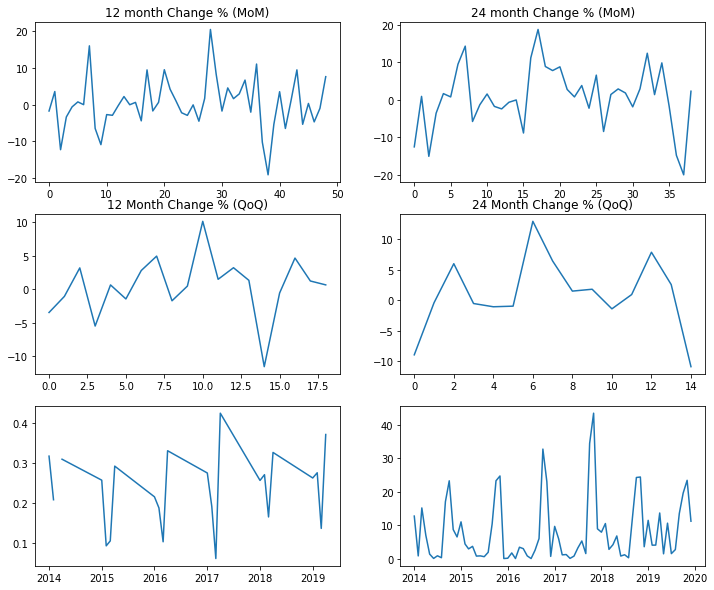

In [388]:
fig, ax=plt.subplots(3,2, figsize=(12,10))
ax[0][1].plot(results.diff(24).groupby([(results.index.year),(results.index.month)]).mean().dropna()['percent'].values)
ax[0][1].set_title("24 month Change % (MoM)");

ax[0][0].plot(results.diff(12).groupby([(results.index.year),(results.index.month)]).mean().dropna()['percent'].values)
ax[0][0].set_title("12 month Change % (MoM)");

ax[1][0].plot(results.diff(12).groupby([(results.index.year),(results.index.quarter)]).mean().dropna()['percent'].values)
ax[1][0].set_title('12 Month Change % (QoQ)');

#ax[1][1].plot(results_y.percent.diff(1))
ax[1][1].plot(results.diff(24).groupby([(results.index.year),(results.index.quarter)]).mean().dropna()['percent'].values)
ax[1][1].set_title('24 Month Change % (QoQ)');

ax[2][0].plot(results_q.ndvi)
ax[2][1].plot(results.percent);

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


In [ ]:
plot_pacf(results['total'], lags=14)

In [ ]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [ ]:
for d in range(1, 14):
    
    # Print out a counter and the corresponding p-value.
    print(f'Checking difference of {d}.')
    print(f'p-value = {interpret_dftest(adfuller(results.total.diff(d).dropna()))["p-value"]}.')
          
    # If our data, differenced by d time periods, are stationary, print that out!
    if interpret_dftest(adfuller(results.total.diff(d).dropna()))['p-value'] < 0.05:
        print(f'Differencing our time series by d={d} yields a stationary time series!')
    
    print()

In [ ]:
model = ARIMA(endog = results.total.diff(2).dropna(), # endog = Y variable
              order = (2,0,2))
arima_1_4_0 = model.fit()
preds = arima_1_4_0.predict()



In [ ]:
mean_squared_error(results.total.diff(2).dropna(), preds)

In [ ]:

arima_1_4_0.forecast(6)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(results_q.total.diff(6).dropna(), color = 'blue')
plt.plot(preds, color = 'orange')
#plt.title(label = 'Bus Ridership with ARIMA(1,4,0) Predictions', fontsize=18)
plt.show();

In [46]:
from fbprophet import Prophet

In [464]:
x=list(results.diff(12).groupby([results.index.year,results.index.quarter])['percent'].mean().dropna().values)

In [324]:
x=list(results_q.ndvi.values)

In [465]:
d=list(pd.date_range(start='2015-01-01', end='2019-12-31', freq='Q'))

In [445]:
temp=pd.DataFrame(list(zip(d,x)), columns = ['ds', 'y'])
#temp=results_q.reset_index()[['date','ndvi']]
#len(d)

In [466]:
#temp=x.loc[:,['d','percent']]
temp.columns = ['ds', 'y']

In [467]:
temp.head()

,ds,y
0,2015-01-31,-1.72
1,2015-02-28,3.58
2,2015-03-31,-12.23
3,2015-04-30,-3.34
4,2015-05-31,-0.59


In [474]:
m = Prophet(daily_seasonality=False, yearly_seasonality=True
            ,mcmc_samples=1000,seasonality_mode='additive',seasonality_prior_scale=20)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_seasonality(name='quarterly', period=365.25/4, fourier_order=7)
m.fit(temp, control={'max_treedepth': 20})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [475]:
future = m.make_future_dataframe(periods=24, freq='Q')
future.tail()

,ds
79,2024-12-31
80,2025-03-31
81,2025-06-30
82,2025-09-30
83,2025-12-31


In [476]:
forecast = m.predict(future)

In [412]:
forecast['y']=temp.y

In [413]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,quarterly,quarterly_lower,quarterly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2016-03-31,-3.280187,-10.217035,5.192730,-81.869960,80.653463,0.660444,-84.782859,79.182435,0.660444,-84.782859,79.182435,0.0,0.0,0.0,-2.619743,-8.933333
1,2016-06-30,-3.273420,-9.733149,6.887117,-81.645471,80.809270,1.834224,-83.568442,80.014711,1.834224,-83.568442,80.014711,0.0,0.0,0.0,-1.439196,-0.406667
2,2016-09-30,-3.267246,-9.181340,5.655566,-81.672334,81.300930,1.836556,-84.015138,79.732119,1.836556,-84.015138,79.732119,0.0,0.0,0.0,-1.430691,-3.183333
3,2016-12-31,-3.264528,-0.080117,17.970239,-81.717279,81.611822,11.757098,-75.178171,89.277417,11.757098,-75.178171,89.277417,0.0,0.0,0.0,8.492570,5.986667
4,2017-03-31,-3.266446,-9.208008,5.699611,-81.697049,82.083894,1.449782,-83.951871,79.549395,1.449782,-83.951871,79.549395,0.0,0.0,0.0,-1.816663,-0.533333


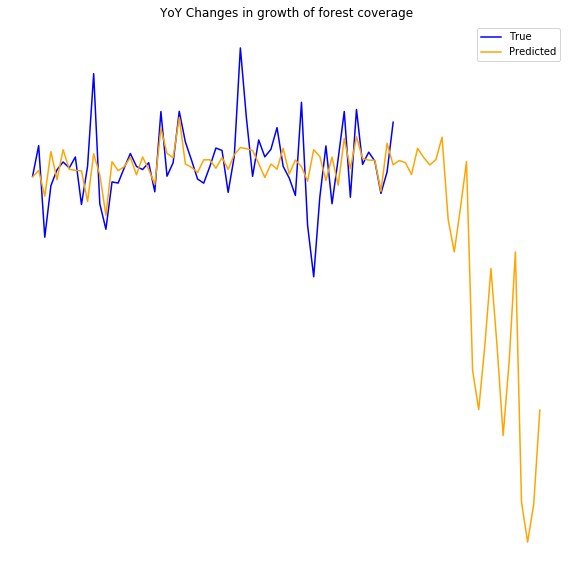

In [489]:
plt.figure(figsize=(10,10))
plt.axis('off')

plt.plot(temp.y, color = 'blue', label='True')
plt.plot(forecast.yhat, color = 'orange' ,label='Predicted')
plt.title("YoY Changes in growth of forest coverage")

plt.legend();
plt.imsave('static/images/sunder_res.png', img, cmap='Greys', dpi=500)

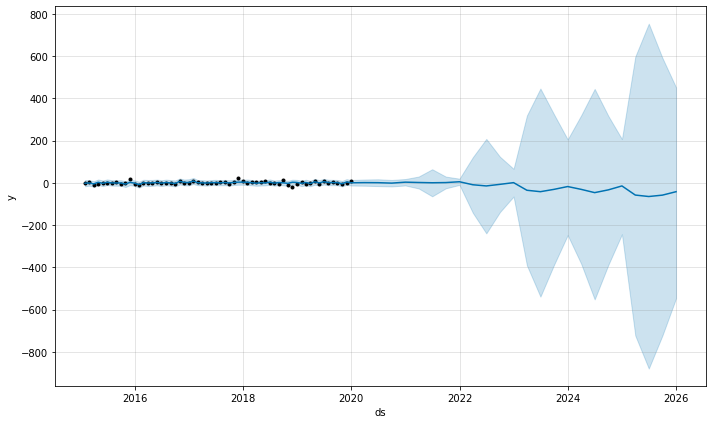

In [478]:
pd.plotting.register_matplotlib_converters()
# known issue in pandas right now
# github issue: https://github.com/facebook/prophet/issues/999

m.plot(forecast);

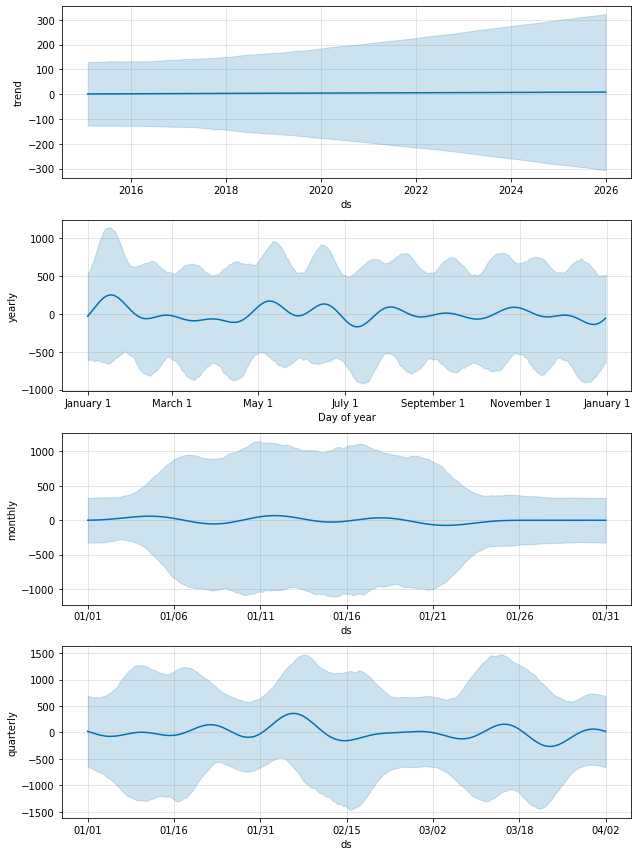

In [479]:
m.plot_components(forecast);

In [493]:
results_q.reset_index(inplace=True)

In [496]:
alt.Chart(results_q).mark_line().encode(
    alt.X('date', axis=alt.Axis(title="")),
    alt.Y('ndvi', axis=alt.Axis(title="Normalized difference vegetation index"))).properties(width=400,height=400)

alt.Chart(...)

In [221]:
def get_mask(links):
    imgs=[]
    for i in links:
        imgs.append(tifffile.imread(i))
    imgs = np.asarray(imgs)
    med = np.nanmedian(imgs, axis=0)
    return med

In [244]:
import matplotlib
for year in data.key_y.unique():
    img=get_mask(data[data['key_y']==year].links.values)
    matplotlib.image.imsave('static/images/Sunder_mask_{}.png'.format(year), img, cmap='Greys', dpi=500)

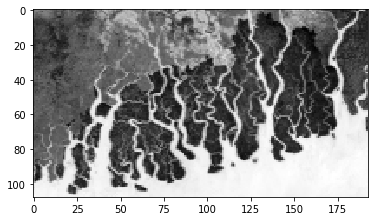

In [225]:
plt.imshow(img, cmap='Greys')